Hello World Agent

In [ ]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph

In [ ]:
class AgentState(TypedDict):
    message: str

def greeting_node(state: AgentState) -> AgentState:
    """ Simple nodes that adds a greeting message to the state"""
    state["message"] = "Hey "+ state["message"] +", how are you doing?"
    return state

def helper_node(state: AgentState) -> AgentState:
    """ Asks for help """
    state["message"] += " Can you help me please!"
    return state

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("greeter", greeting_node)
graph.add_node("helper", helper_node)
graph.add_edge("greeter", "helper")
graph.set_entry_point("greeter")
graph.set_finish_point("helper")

app = graph.compile()

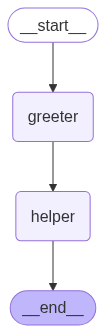

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
result = app.invoke({"message" : "Bob"})
print(result['message'])

Hey Bob, how are you doing? Can you help me please!


Multiple Inputs

In [ ]:
from typing import List, TypedDict
from langgraph.graph import StateGraph, START, END

In [ ]:
class AgentState(TypedDict):
  values: List[int]
  name: str
  result: str

In [ ]:
def process_values(state: AgentState) -> AgentState:
  """ This Function adds up all the value in the result """
  sum_list = sum(state['values'])
  state['result'] = f"Hey {state['name']} your output is {sum_list}"
  return state

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("process_values", process_values)
graph.add_edge(START, "process_values")
graph.add_edge("process_values", END)

app = graph.compile()

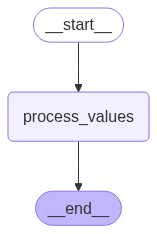

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
res = app.invoke({"name" : "Bob", "values" : [1,2,3,4,5]})
print(res['result'])

Hey Bob your output is 15


Conditional Graph

In [ ]:
from typing import List, TypedDict
from langgraph.graph import StateGraph, START, END

In [ ]:
class AgentState(TypedDict):
  a: int
  b: int
  op: str
  result: int

In [ ]:
def addition(state: AgentState) -> AgentState:
  """" This node adds two number """
  state['result'] = state['a'] + state['b']
  return state

def subtraction(state: AgentState) -> AgentState:
  """" This node subtracts two number """
  state['result'] = state['a'] - state['b']
  return state

def multiplication(state: AgentState) -> AgentState:
  """" This node multiplies two number """
  state['result'] = state['a'] * state['b']
  return state

def division(state: AgentState) -> AgentState:
  """" This node divides two number """
  state['result'] = state['a'] / state['b']
  return state

def decision_node(state: AgentState) -> AgentState:
  """ This node decides which nodes to be next based on operation"""
  if state['op'] == '+':
    return "addition_operation"
  elif state['op'] == '-':
    return "subtraction_operation"
  elif state['op'] == '*':
    return "multiplication_operation"
  elif state['op'] == '/':
    return "divide_operation"


In [ ]:
graph = StateGraph(AgentState)
graph.add_node("add_node", addition)
graph.add_node("sub_ndoe", subtraction)
graph.add_node("mult_node", multiplication)
graph.add_node("div_node", division)
graph.add_node("router", lambda state:state) #pass through function

graph.add_edge(START, "router")
graph.add_conditional_edges(
    "router",
    decision_node,
    {
        # Edge : Node
        "addition_operation": "add_node",
        "subtraction_operation": "sub_ndoe",
        "multiplication_operation": "mult_node",
        "divide_operation": "div_node"
    }

)
graph.add_edge("add_node", END)
graph.add_edge("sub_ndoe", END)
graph.add_edge("mult_node", END)
graph.add_edge("div_node", END)

app = graph.compile()

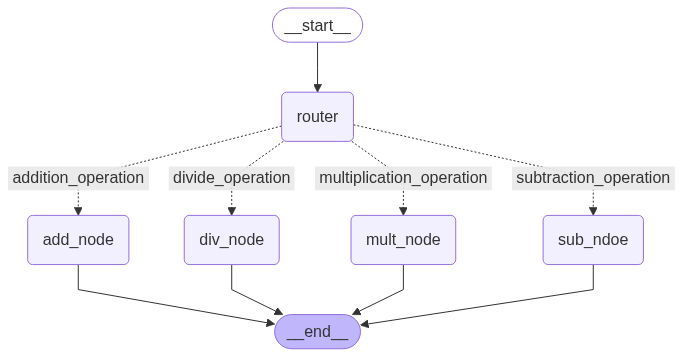

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
init_state = AgentState(a=10, b=5, op="+")
res = app.invoke(init_state)
print(res)

{'a': 10, 'b': 5, 'op': '+', 'result': 15}


Looping Graph

In [ ]:
from typing import List, TypedDict
from langgraph.graph import StateGraph, START, END
import random

In [ ]:
class AgentState(TypedDict):
    name: str
    message: str
    number: List[int]
    counter: int


In [ ]:
def greeting_node(state: AgentState) -> AgentState:
    """ Simple nodes that adds a greeting message to the state"""
    state["message"] = f'Hi there {state["name"]}'
    state["counter"] = 0
    return state

def random_node(state: AgentState) -> AgentState:
    """" Genarte random number """
    state["number"].append(random.randint(0,10))
    state["counter"] += 1

    return state

def should_continue(state: AgentState) -> AgentState:
  """ Router node to take the decision if the loop should continue or not"""
  if state["counter"] < 5:
    print("Entering loop ", state["counter"])
    return "loop"
  else:
    print("Exiting loop ", state["counter"])
    return "exit"

In [ ]:
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)
graph.add_node("random_genarator", random_node)
graph.add_edge("greeter", "random_genarator")

graph.add_conditional_edges(
    "random_genarator",
    should_continue,
    {
        "loop" : "random_genarator",
        "exit" : END
    }
)

graph.add_edge(START, "greeter")
app = graph.compile()

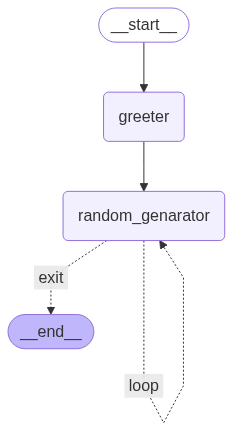

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
init_state = AgentState(name="Bob", number = [])

res = app.invoke(init_state)
print(res)


Entering loop  1
Entering loop  2
Entering loop  3
Entering loop  4
Exiting loop  5
{'name': 'Bob', 'message': 'Hi there Bob', 'number': [9, 4, 7, 10, 2], 'counter': 5}


ReAct Agent

In [ ]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage, HumanMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI


In [ ]:
from dotenv import load_dotenv
load_dotenv()  

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""

    return a + b

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

tools = [add, subtract, multiply]

In [ ]:
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash").bind_tools(tools)

In [ ]:
def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)


tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "our_agent")

app = graph.compile()

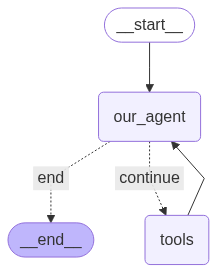

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
init_state = AgentState(messages="todays weather")
print_stream(app.stream(init_state, stream_mode="values"))

================================ Human Message =================================

todays weather
================================== Ai Message ==================================

I am sorry, I cannot fulfill this request. The available tools lack the desired functionality.


How the flow works in ReAct

In [ ]:
query = "precipitation_mm what does is mean"

agent_state: AgentState = {"messages": [HumanMessage(content=query)]}
next_state = model_call(agent_state)
tool_call = next_state["messages"][-1].tool_calls
llm_reply = next_state["messages"][-1].content
print(f'LLM Reply: {llm_reply}')
print(f'Tool Calls: {tool_call}')

LLM Reply: I am sorry, I cannot fulfill this request. The available tools lack the desired functionality.
Tool Calls: []


In [ ]:
decision = should_continue(next_state)
if decision == 'continue':
    res = tool_node.invoke(next_state)
elif decision == 'end':
    res = next_state
res['messages'][-1].content

'7'

Search Tool

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

ddg = DuckDuckGoSearchRun()

ddg.invoke("today date")


"Details about today's date with count of days, weeks, and months, Sun and Moon cycles, Zodiac signs and holidays. Discover today's exact date and time, learn about time zones, date formats, and explore our comprehensive collection of date and time tools including calculators, converters, and calendars. Perfect for planning, scheduling, and time management. 7 million locations, 58 languages, synchronized with atomic clock time. Current local time and date now, with date picker and world clock. RapidTables. Search Share. ... Today's date: day of week, month, day, year. Time zone with location and GMT offset. Date picker of current date. Calendar chart. See also. UK time; New York time; Los Angeles time; Chicago time; Online clock. What time is it in different regions of United States, Canada, Australia, Europe and the World."

Weather API Tool

In [1]:
import requests
from langchain_core.tools import tool

@tool
def get_weather_info(city: str, date: str) -> dict:
    """Returns the weather forecast for a given city and date (YYYY-MM-DD format)."""
    url = f"https://nominatim.openstreetmap.org/search"
    params = {
        "q": city,
        "format": "json",
        "limit": 1
    }
    response = requests.get(url, params=params, headers={"User-Agent": "weather-app"})
    if response.status_code == 200 and response.json():
        data = response.json()[0]
        latitude, longitude = float(data["lat"]), float(data["lon"])
    else:
        return {"success": False, "message": f"City '{city}' not found."}

    forecast_url = (
        f"https://api.open-meteo.com/v1/forecast"
        f"?latitude={latitude}&longitude={longitude}"
        f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum"
        f"&timezone=auto"
        f"&start_date={date}&end_date={date}"
    )

    response = requests.get(forecast_url)
    if response.status_code == 200:
        data = response.json()

        precipitation = data['daily']['precipitation_sum'][0]
        max_temp = data['daily']['temperature_2m_max'][0]
        min_temp = data['daily']['temperature_2m_min'][0]

        # Basic condition inference
        if precipitation > 0:
            condition = "Rainy"
        elif max_temp > 25:
            condition = "Sunny"
        else:
            condition = "Cloudy"

        return {
            "success": True,
            "city": city,
            "date": date,
            "max_temp": max_temp,
            "min_temp": min_temp,
            "precipitation_mm": precipitation,
            "condition": condition
        }
    else:
        return {"success": False, "message": "Weather info could not be fetched."}


In [2]:
from dotenv import load_dotenv
load_dotenv()  

True

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

tools = [get_weather_info]
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash").bind_tools(tools)

In [4]:
result = get_weather_info.invoke({"city": "Dhaka", "date": "2025-06-15"})
print(result)

{'success': True, 'city': 'Dhaka', 'date': '2025-06-15', 'max_temp': 31.9, 'min_temp': 27.3, 'precipitation_mm': 9.6, 'condition': 'Rainy'}


In [5]:
model.invoke("weather of dhaka 2025-06-15")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather_info', 'arguments': '{"city": "dhaka", "date": "2025-06-15"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--76477d7e-9b3d-4347-8f3b-b606470d686f-0', tool_calls=[{'name': 'get_weather_info', 'args': {'city': 'dhaka', 'date': '2025-06-15'}, 'id': '07b8e945-2204-4b90-976a-943a73abf9c9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 45, 'output_tokens': 19, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}})